Thanks ChatGPT for its help. See https://chatgpt.com/share/67db55c5-8ad4-800c-9243-99115ab795d3 for details. 

In [1]:
!wget https://raw.githubusercontent.com/mhibatallah/ML-for-many-body-physics-course/refs/heads/main/FFNN_tutorial_data/x_L30.txt

!wget https://raw.githubusercontent.com/mhibatallah/ML-for-many-body-physics-course/refs/heads/main/FFNN_tutorial_data/y_L30.txt

!wget https://raw.githubusercontent.com/mhibatallah/ML-for-many-body-physics-course/refs/heads/main/FFNN_tutorial_data/T_L30.txt

--2025-03-19 14:30:13--  https://raw.githubusercontent.com/mhibatallah/ML-for-many-body-physics-course/refs/heads/main/FFNN_tutorial_data/x_L30.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
200 OKequest sent, awaiting response... 
Length: 18000000 (17M) [text/plain]
Saving to: ‘x_L30.txt’

x_L30.txt           100%[===================>]  17.17M  3.02MB/s    in 5.7s    

2025-03-19 14:30:19 (3.02 MB/s) - ‘x_L30.txt’ saved [18000000/18000000]

--2025-03-19 14:30:19--  https://raw.githubusercontent.com/mhibatallah/ML-for-many-body-physics-course/refs/heads/main/FFNN_tutorial_data/y_L30.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.

In [1]:
#from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import torch

### (for reproducibility purposes) ###
torch.manual_seed(111)
np.random.seed(111)

x = np.loadtxt("x_L30.txt")
y = np.loadtxt("y_L30.txt")
T = np.loadtxt("T_L30.txt")

/home/shjsfz/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [57]:
# Generate a random permutation of indices
indices = np.random.permutation(len(x))

# Apply the same permutation to x, y, T
x_shuffled = x[indices]
y_shuffled = y[indices]
T_shuffled = T[indices]

# Compute split indices
total_samples = x.shape[0]
train_size = int(0.7 * total_samples)
val_size = int(0.2 * total_samples)

# Split data
x_train = x_shuffled[:train_size]
x_val = x_shuffled[train_size:train_size + val_size]
x_test = x_shuffled[train_size + val_size:]

y_train = y_shuffled[:train_size]
y_val = y_shuffled[train_size:train_size + val_size]
y_test = y_shuffled[train_size + val_size:]

T_test = T_shuffled[train_size + val_size:]

In [3]:
mag_noise = 0.3  # controls how much noise gets added to the data
dTheta    = 4    # difference in theta in each branch

2. (a)

In [71]:
%matplotlib inline
from IPython import display

import time
import torch

class FeedforwardNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()

        #layer sizes:
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        #functions used within the Feedforward NN:
        self.linear1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu    = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(self.hidden_size, self.output_size)  # Hidden to output layer
        self.sigmoid = torch.nn.Sigmoid()
        #self.softmax = torch.nn.Softmax(dim=1)
    def forward(self, x):
        #Layer 1:
        hidden_out = self.linear1(x)
        a1 = self.relu(hidden_out)

        output = self.linear2(a1)    # Hidden to output layer
        aL = self.sigmoid(output)    # Sigmoid activation for output layer (if classification)
        #Network output:
        # aL = a1

        return aL


In [ ]:
input_size = x_train.shape[1]    # Input data x only has 900 features
hidden_size = 100  # Add hidden layer with 100 neurons
output_size = 2   # Classify the states into FM and PM
model = FeedforwardNN(input_size, hidden_size, output_size)

### Store the input data as a PyTorch tensor ###
x_train = torch.tensor(x_train, dtype = torch.float)

## One hot encoding ###
y_onehot = np.zeros((y_train.size, 2))
y_onehot[np.arange(y_train.size),y_train.astype(int)] = 1
y_onehot = torch.tensor(y_onehot, dtype = torch.float)

## One hot encoding of validation data
y_val_onehot = np.zeros((y_val.size, 2))
y_val_onehot[np.arange(y_val.size),y_val.astype(int)] = 1
y_val_onehot = torch.tensor(y_val_onehot, dtype = torch.float)

## Convert numpy arrays to PyTorch tensors
x_val = torch.tensor(x_val, dtype=torch.float)

### Use backpropagation to minimize the cost function using the gradient descent algorithm: ###
learning_rate = 1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Cost function: ###
cost_func = torch.nn.MSELoss()

N_epochs = 10000 # number of times to run gradient descent

Final Training cost 0.003137
Final Training accuracy 0.997143



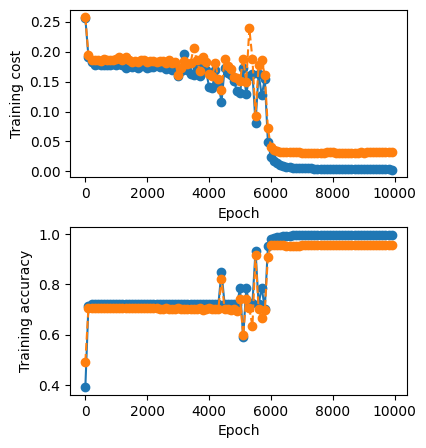

In [61]:
epoch_list    = []
cost_training = []
acc_training  = []

############ Function for plotting: ############
def updatePlot():
    ### Plot the cost function during training: ###
    plt.subplot(222)
    plt.plot(epoch_list,cost_training,'o-')
    plt.plot(epoch_list, val_losses, 'o-', label='Validation cost', linestyle='--')  # Validation cost
    plt.xlabel('Epoch')
    plt.ylabel('Training cost')

    ### Plot the training accuracy: ###
    plt.subplot(224)
    plt.plot(epoch_list,acc_training,'o-')
    plt.plot(epoch_list, val_accuracies, 'o-', label='Validation accuracy', linestyle='--')  # Validation accuracy
    plt.xlabel('Epoch')
    plt.ylabel('Training accuracy')
############ End of plotting function ############

val_losses = []
val_accuracies = []

### Train for several epochs: ###
for epoch in range(N_epochs):

    optimizer.zero_grad() # sets the gradients to zero (necessary since PyTorch accumulates the gradients)
    NN_output = model(x_train) # Neural network output
    cost = cost_func(NN_output, y_onehot)
    cost.backward() #computes the gradients
    optimizer.step() #updating the parameters

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradients needed for validation
        NN_val_output = model(x_val)  # Neural network output on validation data
        val_loss = cost_func(NN_val_output, y_val_onehot)  # Validation loss
        predicted_val_class = np.argmax(NN_val_output.detach().numpy(), axis=1)
        val_accuracy = np.mean(predicted_val_class == y_val)  # Validation accuracy
    
    ### Update the plot and print results every 500 epochs: ###
    if epoch % 100 == 0:
        predicted_class = np.argmax(NN_output.detach().numpy(), axis=1)
        accuracy = np.mean(predicted_class == y_train)

        epoch_list.append(epoch)
        cost_training.append(cost.detach().numpy())
        acc_training.append(accuracy)

        # Validation metrics
        val_losses.append(val_loss.detach().numpy())
        val_accuracies.append(val_accuracy)

        ### Update the plot of the resulting classifier: ###
        fig = plt.figure(2,figsize=(10,5))
        fig.subplots_adjust(hspace=.3,wspace=.3)
        plt.clf()
        updatePlot()
        display.display(plt.gcf())
        print("Iteration %d:\n  Training cost %f\n  Training accuracy %f\n" % (epoch, cost, accuracy) )
        print("Iteration %d:\n  Validation cost %f\n  Validation accuracy %f\n" % (epoch, val_loss, val_accuracy) )
        display.clear_output(wait=True)
        time.sleep(0.1) #Uncomment this line if you want to slow down the rate of plot updates

plt.savefig('Training.pdf', bbox_inches="tight")
print("Final Training cost %f\nFinal Training accuracy %f\n" % (cost, accuracy) )

In [62]:
print("Final Validation cost %f\nFinal Validation accuracy %f\n" % (val_loss, val_accuracy) )

Final Validation cost 0.031598
Final Validation accuracy 0.956500



There is a gap between training accuracy and validation accuracy. So it is some overfitting

2. (b)

In [4]:
%matplotlib inline
from IPython import display

import time
import torch

class FeedforwardNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()

        #layer sizes:
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        #functions used within the Feedforward NN:
        self.linear1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu    = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(self.hidden_size, self.output_size)  # Hidden to output layer
        self.sigmoid = torch.nn.Sigmoid()
        #self.softmax = torch.nn.Softmax(dim=1)
    def forward(self, x):
        #Layer 1:
        hidden_out = self.linear1(x)
        a1 = self.relu(hidden_out)

        output = self.linear2(a1)    # Hidden to output layer
        aL = self.sigmoid(output)    # Sigmoid activation for output layer (if classification)
        #Network output:
        # aL = a1

        return aL


In [9]:
input_size = x_train.shape[1]    # Input data x only has 900 features
hidden_size = 100  # Add hidden layer with 100 neurons
output_size = 2   # Classify the states into FM and PM
model = FeedforwardNN(input_size, hidden_size, output_size)

### Store the input data as a PyTorch tensor ###
x_train = torch.tensor(x_train, dtype = torch.float)

## One hot encoding ###
y_onehot = np.zeros((y_train.size, 2))
y_onehot[np.arange(y_train.size),y_train.astype(int)] = 1
y_onehot = torch.tensor(y_onehot, dtype = torch.float)

## One hot encoding of validation data
y_val_onehot = np.zeros((y_val.size, 2))
y_val_onehot[np.arange(y_val.size),y_val.astype(int)] = 1
y_val_onehot = torch.tensor(y_val_onehot, dtype = torch.float)

## Convert numpy arrays to PyTorch tensors
x_val = torch.tensor(x_val, dtype=torch.float)

### Use backpropagation to minimize the cost function using the gradient descent algorithm: ###
learning_rate = 1

### Cost function: ###
cost_func = torch.nn.MSELoss()

N_epochs = 10000 # number of times to run gradient descent
weight_decay_value = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay_value)

Final Training cost 0.164144
Final Training accuracy 0.660000

Final Validation cost 0.187728
Final Validation accuracy 0.719500



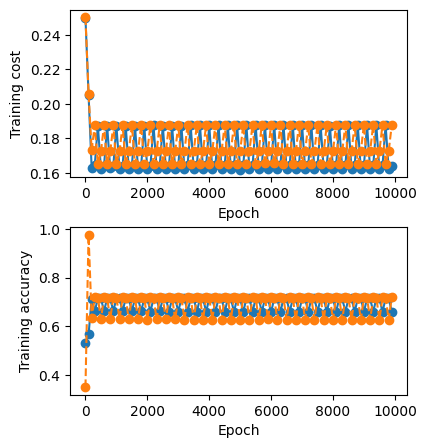

In [10]:
epoch_list    = []
cost_training = []
acc_training  = []

############ Function for plotting: ############
def updatePlot():
    ### Plot the cost function during training: ###
    plt.subplot(222)
    plt.plot(epoch_list,cost_training,'o-')
    plt.plot(epoch_list, val_losses, 'o-', label='Validation cost', linestyle='--')  # Validation cost
    plt.xlabel('Epoch')
    plt.ylabel('Training cost')

    ### Plot the training accuracy: ###
    plt.subplot(224)
    plt.plot(epoch_list,acc_training,'o-')
    plt.plot(epoch_list, val_accuracies, 'o-', label='Validation accuracy', linestyle='--')  # Validation accuracy
    plt.xlabel('Epoch')
    plt.ylabel('Training accuracy')
############ End of plotting function ############

val_losses = []
val_accuracies = []

### Train for several epochs: ###
for epoch in range(N_epochs):

    optimizer.zero_grad() # sets the gradients to zero (necessary since PyTorch accumulates the gradients)
    NN_output = model(x_train) # Neural network output
    cost = cost_func(NN_output, y_onehot)
    cost.backward() #computes the gradients
    optimizer.step() #updating the parameters

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradients needed for validation
        NN_val_output = model(x_val)  # Neural network output on validation data
        val_loss = cost_func(NN_val_output, y_val_onehot)  # Validation loss
        predicted_val_class = np.argmax(NN_val_output.detach().numpy(), axis=1)
        val_accuracy = np.mean(predicted_val_class == y_val)  # Validation accuracy
    
    ### Update the plot and print results every 500 epochs: ###
    if epoch % 100 == 0:
        predicted_class = np.argmax(NN_output.detach().numpy(), axis=1)
        accuracy = np.mean(predicted_class == y_train)

        epoch_list.append(epoch)
        cost_training.append(cost.detach().numpy())
        acc_training.append(accuracy)

        # Validation metrics
        val_losses.append(val_loss.detach().numpy())
        val_accuracies.append(val_accuracy)

        ### Update the plot of the resulting classifier: ###
        fig = plt.figure(2,figsize=(10,5))
        fig.subplots_adjust(hspace=.3,wspace=.3)
        plt.clf()
        updatePlot()
        display.display(plt.gcf())
        print("Iteration %d:\n  Training cost %f\n  Training accuracy %f\n" % (epoch, cost, accuracy) )
        print("Iteration %d:\n  Validation cost %f\n  Validation accuracy %f\n" % (epoch, val_loss, val_accuracy) )
        display.clear_output(wait=True)
        time.sleep(0.1) #Uncomment this line if you want to slow down the rate of plot updates

plt.savefig(f'Weightdecay{weight_decay_value}.pdf', bbox_inches="tight")
print("Final Training cost %f\nFinal Training accuracy %f\n" % (cost, accuracy) )
print("Final Validation cost %f\nFinal Validation accuracy %f\n" % (val_loss, val_accuracy) )

In [11]:
plt.savefig(f'Weightdecay{weight_decay_value}.pdf', bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

After adding weight decay=0.01, Final Validation accuracy 0.719500 > Final Training accuracy 0.660000. There is no overfitting, but the accuracy decreases and training cost increase. Accuracy and cost do not corverge, then keep oscillating.

In [12]:
# Modify weight_decay_value
weight_decay_value = 0.001

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay_value)

Final Training cost 0.181802
Final Training accuracy 0.716143

Final Validation cost 0.183350
Final Validation accuracy 0.715000



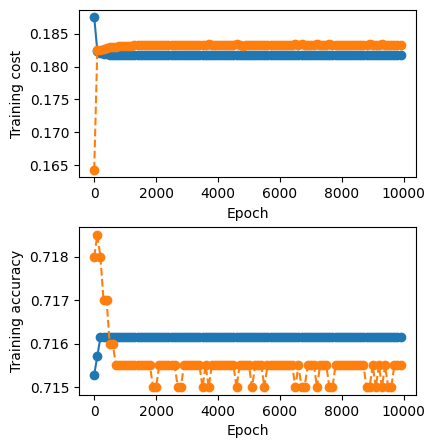

In [13]:
epoch_list    = []
cost_training = []
acc_training  = []

############ Function for plotting: ############
def updatePlot():
    ### Plot the cost function during training: ###
    plt.subplot(222)
    plt.plot(epoch_list,cost_training,'o-')
    plt.plot(epoch_list, val_losses, 'o-', label='Validation cost', linestyle='--')  # Validation cost
    plt.xlabel('Epoch')
    plt.ylabel('Training cost')

    ### Plot the training accuracy: ###
    plt.subplot(224)
    plt.plot(epoch_list,acc_training,'o-')
    plt.plot(epoch_list, val_accuracies, 'o-', label='Validation accuracy', linestyle='--')  # Validation accuracy
    plt.xlabel('Epoch')
    plt.ylabel('Training accuracy')
############ End of plotting function ############

val_losses = []
val_accuracies = []

### Train for several epochs: ###
for epoch in range(N_epochs):

    optimizer.zero_grad() # sets the gradients to zero (necessary since PyTorch accumulates the gradients)
    NN_output = model(x_train) # Neural network output
    cost = cost_func(NN_output, y_onehot)
    cost.backward() #computes the gradients
    optimizer.step() #updating the parameters

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradients needed for validation
        NN_val_output = model(x_val)  # Neural network output on validation data
        val_loss = cost_func(NN_val_output, y_val_onehot)  # Validation loss
        predicted_val_class = np.argmax(NN_val_output.detach().numpy(), axis=1)
        val_accuracy = np.mean(predicted_val_class == y_val)  # Validation accuracy
    
    ### Update the plot and print results every 500 epochs: ###
    if epoch % 100 == 0:
        predicted_class = np.argmax(NN_output.detach().numpy(), axis=1)
        accuracy = np.mean(predicted_class == y_train)

        epoch_list.append(epoch)
        cost_training.append(cost.detach().numpy())
        acc_training.append(accuracy)

        # Validation metrics
        val_losses.append(val_loss.detach().numpy())
        val_accuracies.append(val_accuracy)

        ### Update the plot of the resulting classifier: ###
        fig = plt.figure(2,figsize=(10,5))
        fig.subplots_adjust(hspace=.3,wspace=.3)
        plt.clf()
        updatePlot()
        display.display(plt.gcf())
        print("Iteration %d:\n  Training cost %f\n  Training accuracy %f\n" % (epoch, cost, accuracy) )
        print("Iteration %d:\n  Validation cost %f\n  Validation accuracy %f\n" % (epoch, val_loss, val_accuracy) )
        display.clear_output(wait=True)
        time.sleep(0.1) #Uncomment this line if you want to slow down the rate of plot updates

plt.savefig(f'Weightdecay{weight_decay_value}.pdf', bbox_inches="tight")
print("Final Training cost %f\nFinal Training accuracy %f\n" % (cost, accuracy) )
print("Final Validation cost %f\nFinal Validation accuracy %f\n" % (val_loss, val_accuracy) )

After setting Weightdecay=0.001, the training cost and accuracy converge and training accuracy increases. Training accuracy is slightly higher than Validation accuracy, but the difference is lower that the case when Weightdecay=0

2. c

In [66]:
input_size = x_train.shape[1]    # Input data x only has 900 features
hidden_size = 100  # Add hidden layer with 100 neurons
output_size = 2   # Classify the states into FM and PM
model = FeedforwardNN(input_size, hidden_size, output_size)

### Store the input data as a PyTorch tensor ###
x_train = torch.tensor(x_train, dtype = torch.float)

## One hot encoding ###
y_onehot = np.zeros((y_train.size, 2))
y_onehot[np.arange(y_train.size),y_train.astype(int)] = 1
y_onehot = torch.tensor(y_onehot, dtype = torch.float)

## One hot encoding of validation data
y_val_onehot = np.zeros((y_val.size, 2))
y_val_onehot[np.arange(y_val.size),y_val.astype(int)] = 1
y_val_onehot = torch.tensor(y_val_onehot, dtype = torch.float)

## Convert numpy arrays to PyTorch tensors
x_val = torch.tensor(x_val, dtype=torch.float)

### Use backpropagation to minimize the cost function using the gradient descent algorithm: ###
learning_rate = 1

### Cost function: ###
cost_func = torch.nn.MSELoss()

N_epochs = 10000 # number of times to run gradient descent
weight_decay_value = 0.005

optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=weight_decay_value)  # Lower learning rate recommended for Adam

/tmp/ipykernel_37314/3055876618.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype = torch.float)
/tmp/ipykernel_37314/3055876618.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=torch.float)


Final Training cost 0.022778
Final Training accuracy 0.997143

Final Validation cost 0.040598
Final Validation accuracy 0.981000



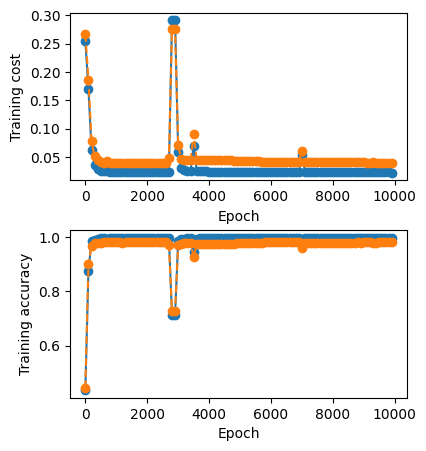

In [67]:
epoch_list    = []
cost_training = []
acc_training  = []

############ Function for plotting: ############
def updatePlot():
    ### Plot the cost function during training: ###
    plt.subplot(222)
    plt.plot(epoch_list,cost_training,'o-')
    plt.plot(epoch_list, val_losses, 'o-', label='Validation cost', linestyle='--')  # Validation cost
    plt.xlabel('Epoch')
    plt.ylabel('Training cost')

    ### Plot the training accuracy: ###
    plt.subplot(224)
    plt.plot(epoch_list,acc_training,'o-')
    plt.plot(epoch_list, val_accuracies, 'o-', label='Validation accuracy', linestyle='--')  # Validation accuracy
    plt.xlabel('Epoch')
    plt.ylabel('Training accuracy')
############ End of plotting function ############

val_losses = []
val_accuracies = []

### Train for several epochs: ###
for epoch in range(N_epochs):

    optimizer.zero_grad() # sets the gradients to zero (necessary since PyTorch accumulates the gradients)
    NN_output = model(x_train) # Neural network output
    cost = cost_func(NN_output, y_onehot)
    cost.backward() #computes the gradients
    optimizer.step() #updating the parameters

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradients needed for validation
        NN_val_output = model(x_val)  # Neural network output on validation data
        val_loss = cost_func(NN_val_output, y_val_onehot)  # Validation loss
        predicted_val_class = np.argmax(NN_val_output.detach().numpy(), axis=1)
        val_accuracy = np.mean(predicted_val_class == y_val)  # Validation accuracy
    
    ### Update the plot and print results every 500 epochs: ###
    if epoch % 100 == 0:
        predicted_class = np.argmax(NN_output.detach().numpy(), axis=1)
        accuracy = np.mean(predicted_class == y_train)

        epoch_list.append(epoch)
        cost_training.append(cost.detach().numpy())
        acc_training.append(accuracy)

        # Validation metrics
        val_losses.append(val_loss.detach().numpy())
        val_accuracies.append(val_accuracy)

        ### Update the plot of the resulting classifier: ###
        fig = plt.figure(2,figsize=(10,5))
        fig.subplots_adjust(hspace=.3,wspace=.3)
        plt.clf()
        updatePlot()
        display.display(plt.gcf())
        print("Iteration %d:\n  Training cost %f\n  Training accuracy %f\n" % (epoch, cost, accuracy) )
        print("Iteration %d:\n  Validation cost %f\n  Validation accuracy %f\n" % (epoch, val_loss, val_accuracy) )
        display.clear_output(wait=True)
        time.sleep(0.1) #Uncomment this line if you want to slow down the rate of plot updates

plt.savefig(f'Weightdecay{weight_decay_value}.pdf', bbox_inches="tight")
print("Final Training cost %f\nFinal Training accuracy %f\n" % (cost, accuracy) )
print("Final Validation cost %f\nFinal Validation accuracy %f\n" % (val_loss, val_accuracy) )

The highest validation accuracy isaround 0.98 with weight_decay=0.005, Adam optimizer, learning rate =1, neurons=100

2. (d)

In [68]:
## One hot encoding of test data
y_test_onehot = np.zeros((y_test.size, 2))
y_test_onehot[np.arange(y_test.size),y_test.astype(int)] = 1
y_test_onehot = torch.tensor(y_test_onehot, dtype = torch.float)

## Convert numpy arrays to PyTorch tensors
x_test_torch = torch.tensor(x_test, dtype=torch.float)

# Ensure model is in evaluation mode
model.eval()

# Forward pass on test data
with torch.no_grad():  # No need to compute gradients
    test_output = model(x_test_torch)

# Convert outputs to predicted class labels
predicted_test_class = np.argmax(test_output.numpy(), axis=1)

# Compute test accuracy
test_accuracy = np.mean(predicted_test_class ==y_test)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Final Test Accuracy: 0.9860


The final Test Accuracy: 0.9860 is still smaller than that of Ref, which is 0.99

2. (e)

In [69]:
unique_temps = np.unique(T_test)

# Store results
avg_accuracy_per_temp = []
avg_output_per_temp = []

# Compute accuracy and average output per temperature
for temp in unique_temps:
    indices = np.where(T_test == temp)[0]  # Find indices for this temperature
    
    if len(indices) > 0:
        accuracy = np.mean(predicted_test_class[indices] == y_test[indices])
        avg_nn_output = np.mean(test_output.numpy()[indices], axis=0)

        avg_accuracy_per_temp.append(accuracy)
        avg_output_per_temp.append(avg_nn_output)

# Convert lists to arrays for plotting
avg_output_per_temp = np.array(avg_output_per_temp)  # Shape (num_temps, 2)

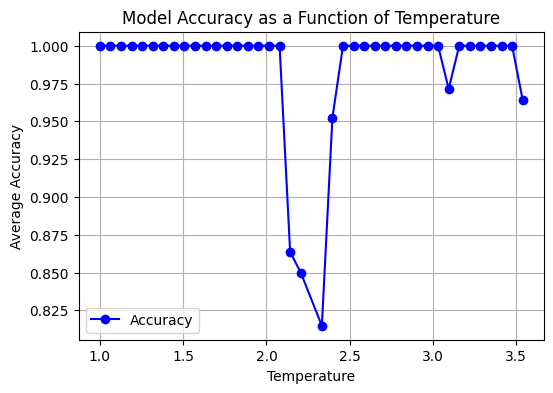

<Figure size 640x480 with 0 Axes>

In [75]:
#Plot Accuracy vs Temperature
plt.figure(figsize=(6, 4))
plt.plot(unique_temps, avg_accuracy_per_temp, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Temperature')
plt.ylabel('Average Accuracy')
plt.title('Model Accuracy as a Function of Temperature')
plt.legend()
plt.grid()
plt.show()
plt.savefig("Accuracy-temp.png")

At $T$ close to $T_c\approx 2.269$, the average accuracy significantly decreases, which is consistent with one's expectation. 

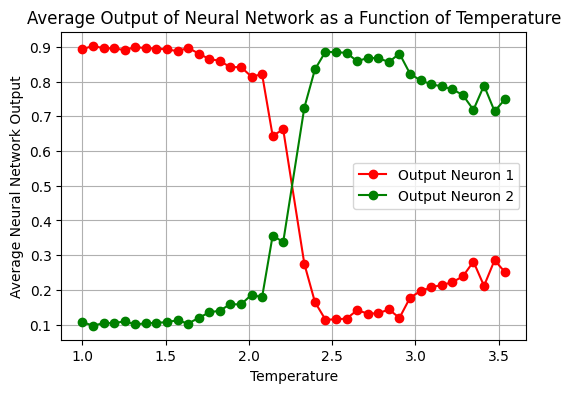

<Figure size 640x480 with 0 Axes>

In [76]:
#Plot Neural Network Output vs Temperature
plt.figure(figsize=(6, 4))
plt.plot(unique_temps, avg_output_per_temp[:, 0], marker='o', linestyle='-', label='Output Neuron 1', color='r')
plt.plot(unique_temps, avg_output_per_temp[:, 1], marker='o', linestyle='-', label='Output Neuron 2', color='g')
plt.xlabel('Temperature')
plt.ylabel('Average Neural Network Output')
plt.title('Average Output of Neural Network as a Function of Temperature')
plt.legend()
plt.grid()
plt.show()
plt.savefig("Output-temp.png")

From the output-temp figure, we can also see the phase transition. However, the accuracy is not as good as the Figure.1 of Ref.